In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
latest_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
print(np.ravel(latest_date))

['2017-08-23']


Most Recent Date: 2017-08-23
One year prior: 2016-08-23


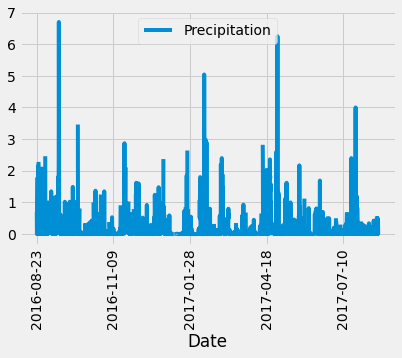

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.date(2017,8,23)
print(f"Most Recent Date: {latest_date}")

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f"One year prior: {year_ago}")

# Perform a query to retrieve the data and precipitation scores
session.query(measurements.date, measurements.prcp).\
    filter(measurements.date >= year_ago).\
    order_by(measurements.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(session.query(measurements.date, measurements.prcp).\
    filter(measurements.date >= year_ago).\
    order_by(measurements.date.desc()).all())

# Sort the dataframe by date
precipitation_df = precipitation_df.rename(columns={0:"Date",1:"Precipitation"}).sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="Date",y="Precipitation",rot=90)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
number_of_stations = session.query(measurements.station).distinct().count()
print(f"Number of Stations: {number_of_stations}")

Number of Stations: 9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_frequency = session.query(measurements.station, func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).all()
    
station_frequency_df = pd.DataFrame(station_frequency,columns=['Station','Frequency'])
station_frequency_df

,Station,Frequency
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_frequent_station = station_frequency_df['Station'][0]
print(f"Most Used Station: {most_frequent_station}")

temps = [func.min(measurements.tobs),func.max(measurements.tobs),func.avg(measurements.tobs)]

lowest_temp = session.query(func.min(measurements.tobs)).\
                filter(measurements.station == most_frequent_station).all()[0]

highest_temp = session.query(func.max(measurements.tobs)).\
                filter(measurements.station == most_frequent_station).all()[0]

average_temp = session.query(func.avg(measurements.tobs)).\
                filter(measurements.station == most_frequent_station).all()[0]

temps_list = list(np.ravel([lowest_temp,highest_temp,average_temp]))

print(f"Lowest Temperature: {temps_list[0]}")
print(f"Highest Temperature: {temps_list[1]}")
print(f"Average Temperature: {round(temps_list[2],1)}")

Most Used Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.7


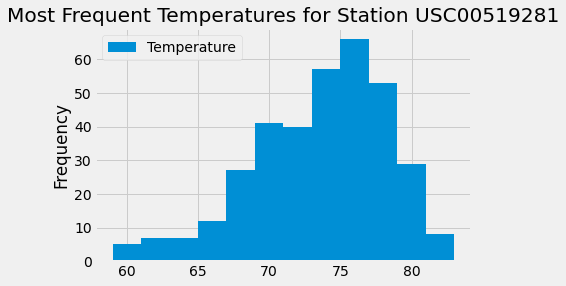

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the data and precipitation scores
station_temp_data = session.query(measurements.date, measurements.tobs).\
    filter(measurements.date >= year_ago).\
    filter(measurements.station == 'USC00519281').\
    order_by(measurements.date.desc()).all()

best_station_df = pd.DataFrame(station_temp_data,columns=['Date','Temperature'])

best_station_df.plot.hist(title=f'Most Frequent Temperatures for Station USC00519281', bins=12)
plt.show()


# Close session

In [16]:
# Close Session
session.close()